In [1]:
 # used to handle data
import pandas as pd

# used to handle gcp data

import geopandas as gpd
from shapely.ops import nearest_points
import shapely.geometry

# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np
from scipy.interpolate import griddata

# Plotting library
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cbook
from matplotlib.colors import LightSource
import seaborn as sns


import folium

# tells matplotlib to embed plots within the notebook
%matplotlib inline



# Geodetic Project
### RTK drone

Read data

In [3]:
df = pd.read_csv(r'data\GCP.csv')
df2 = pd.read_csv(r'data\calibrated_images_position.csv')

# Create GCPs GoeDataFrame
points = gpd.points_from_xy(x=df.x, y=df.y)
df['geometry'] = points
gcp = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:2039")

# Create images positions GoeDataFrame
img_points = gpd.points_from_xy(x=df2.x, y=df2.y)
df2['geometry'] = img_points
img = gpd.GeoDataFrame(df2, geometry='geometry', crs="EPSG:2039")

# # saving to shapefile
# gcp.to_file('GCP.shp')


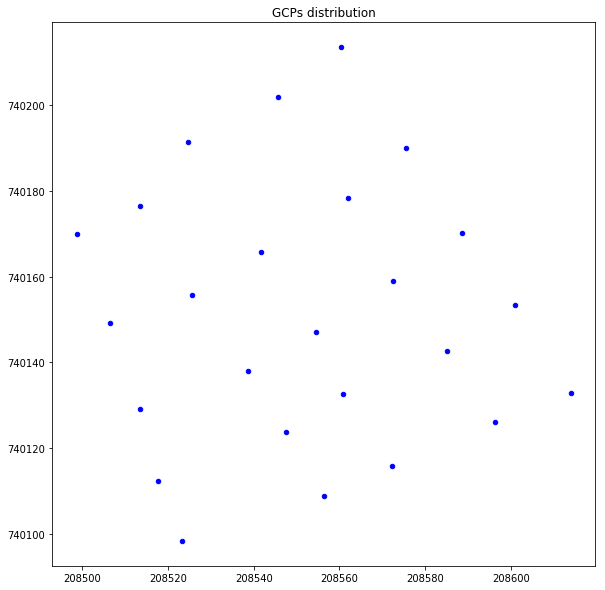

In [4]:
# 2D plot
gcp.plot(figsize=(10, 10), color='b', markersize=20)
plt.title('GCPs distribution')
plt.savefig('GCPs distribution.png')

In [5]:
# # map plot
#
# # convert from ITM to WGS84
# interFeature = gcp.to_crs("+proj=tmerc +lat_0=31.7343936111111 +lon_0=35.2045169444445 +k=1.0000067 +x_0=219529.584 +y_0=626907.39 +ellps=GRS80 +towgs84=-23.772,-17.490,-17.859,-0.31320,-1.85274,1.67299,5.4262 +units=m +no_defs")
# crs_4326 =  {'init': 'epsg:4326'}
# gcp_4326 = interFeature.to_crs(crs_4326)
#
# lats = gcp_4326.geometry.y
# lons = gcp_4326.geometry.x
# names = gcp_4326['point']
# centrum = [lats.mean(),lons.mean()]
#
# map=folium.Map(location=centrum,
#                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#                attr = 'Esri',
#                name = 'Esri Satellite',
#                zoom_start=16)
# # map=folium.Map(location=centrum,zoom_start=16)
#
# # tile = folium.TileLayer(
# #         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
# #         attr = 'Esri',
# #         name = 'Esri Satellite',
# #         overlay = False,
# #         control = True
# #        ).add_to(map)
#
# for lat,lon,name in zip(lats,lons,names):
#     map.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name))))
# map

C:\Users\DELL\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\DELL\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\DELL\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


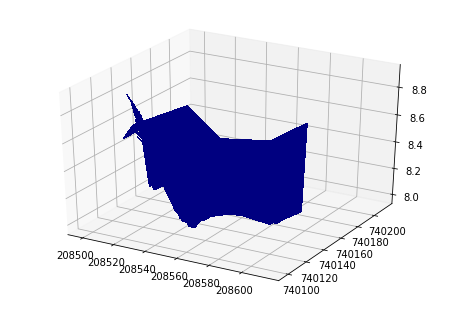

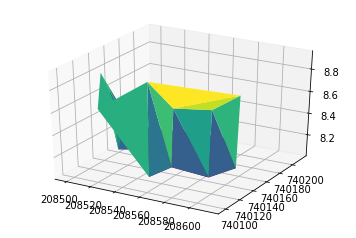

In [6]:
# 3D plot
# option 1
X, Y= np.meshgrid(df.x, df.y)
Z = griddata((df['x'], df['y']), df['z'], (X, Y), method='cubic')

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()

# option 2
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df.x, df.y, df.z, cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

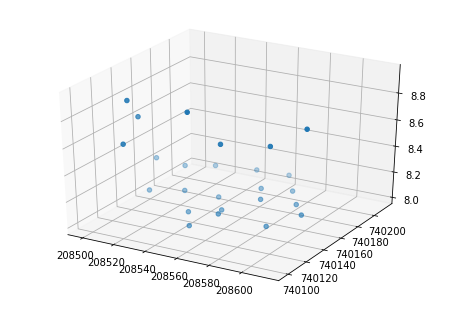

In [7]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df.x, df.y, df.z)
plt.show()

# # to Add a color bar which maps values to colors.
# surf=ax.plot_trisurf(df['y'], df['x'], df['z'], cmap=plt.cm.viridis, linewidth=0.2)
# fig.colorbar( surf, shrink=0.5, aspect=5)
# plt.show()

In [8]:
def map_plot(geoDataFrame, crs=None, tiles=None):
    """

    :param geoDataFrame: GeoPandas.GeoDataFrame
    :param crs: coordinate system
    :param tile: “OpenStreetMap”
                “Mapbox Bright” (Limited levels of zoom for free tiles)
                “Mapbox Control Room” (Limited levels of zoom for free tiles)
                “Stamen” (Terrain, Toner, and Watercolor)
                “Cloudmade” (Must pass API key)
                “Mapbox” (Must pass API key)
                “CartoDB” (positron and dark_matter)
    :return: map with points
    """
    # convert from ITM to WGS84
    if crs == "EPSG:2039":
        interFeature = geoDataFrame.to_crs("+proj=tmerc +lat_0=31.7343936111111 +lon_0=35.2045169444445 +k=1.0000067 +x_0=219529.584 +y_0=626907.39 +ellps=GRS80 +towgs84=-23.772,-17.490,-17.859,-0.31320,-1.85274,1.67299,5.4262 +units=m +no_defs")
        crs_4326 =  {'init': 'epsg:4326'}
        geoDataFrame_4326 = interFeature.to_crs(crs_4326)

    # map
    lats = geoDataFrame_4326.geometry.y
    lons = geoDataFrame_4326.geometry.x
    names = geoDataFrame_4326.iloc[:,0]
    centrum = [lats.mean(),lons.mean()]

    if tiles == 'Esri':
        map=folium.Map(location=centrum,
                       tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                       attr = 'Esri',
                       name = 'Esri Satellite',
                       zoom_start=16)
    else:
        map=folium.Map(location=centrum, tiles=tiles,zoom_start=16)

    for lat,lon,name in zip(lats,lons,names):
        map.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name))))
    return map

In [9]:
map_plot(gcp,'EPSG:2039','OpenStreetMap')

C:\Users\DELL\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [10]:
map_plot(gcp,'EPSG:2039','Esri')

C:\Users\DELL\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
map_plot(img,'EPSG:2039','Esri')

C:\Users\DELL\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Errors
Checking configurations errors

In [50]:
rms1 = pd.read_csv(r'data\points_errors_No_GCP_acc.csv')
rms2 = pd.read_csv(r'data\points_errors_No_GCP_Inacc.csv')
rms3 = pd.read_csv(r'data\points_errors_5GCP_E_acc.csv')

In [51]:
# Create GoeDataFrame
points2 = gpd.points_from_xy(x=rms3.x, y=rms3.y)
rms3['geometry'] = points2
rms3 = gpd.GeoDataFrame(rms3, geometry='geometry', crs="EPSG:2039")

In [6]:
# calculate total error
for i, row in rms1.iterrows():
    rms1.loc[i,'error'] = np.sqrt(row['Error X']**2+row['Error Y']**2+row['Error Z']**2)
for i, row in rms2.iterrows():
    rms2.loc[i,'error'] = np.sqrt(row['Error X']**2+row['Error Y']**2+row['Error Z']**2)
for i, row in rms3.iterrows():
    rms3.loc[i,'error'] = np.sqrt(row['Error X']**2+row['Error Y']**2+row['Error Z']**2)

In [13]:
rms1['error'].describe()

count    25.000000
mean     10.301181
std       0.015772
min      10.277318
25%      10.289705
50%      10.299143
75%      10.310744
max      10.337090
Name: error, dtype: float64

In [14]:
rms2['error'].describe()

count    25.000000
mean     27.006071
std       0.294908
min      26.354747
25%      26.789540
50%      27.096812
75%      27.234055
max      27.340395
Name: error, dtype: float64

In [7]:
rms3['error'].describe()


count    25.000000
mean      0.025268
std       0.009548
min       0.008209
25%       0.020555
50%       0.024555
75%       0.030660
max       0.043417
Name: error, dtype: float64

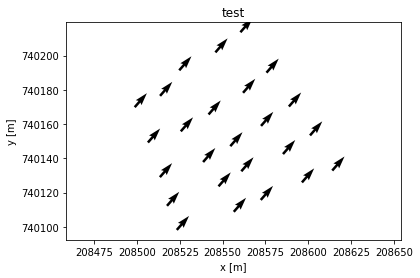

In [39]:
plt.figure()
# plt.quiver(rms1['x'], rms1['y'], 0, rms1['Error Z'] )
plt.quiver(rms1['x'], rms1['y'], rms1['Error X'], rms1['Error Y'] )
plt.title('test')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.show()

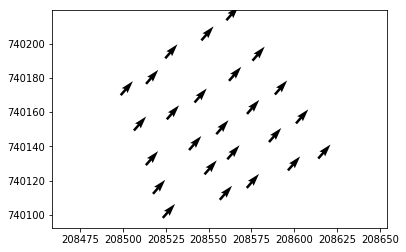

In [43]:

fig, ax = plt.subplots()
q = ax.quiver(rms1['x'], rms1['y'], rms1['Error X'], rms1['Error Y'] )
ax.quiverkey(q, X=0.3, Y=1.1, U=0.7,
             label='Quiver key, length = 0.7 m', labelpos='E')
plt.axis('equal')
plt.show()

In [8]:
# def plot_errors(file_path,key_size):
#
#     rms = pd.read_csv(file_path)
#
#     # calculate horizontal error
#     for i,row in rms.iterrows():
#         rms.loc[i,'error'] = np.sqrt(row['Error X']**2+row['Error Y']**2)
#
#     print(rms['error'].describe())
#
#     fig, ax = plt.subplots(figsize=(15,10))
#     q = ax.quiver(rms['x'], rms['y'], rms['Error X'], rms['Error Y'] )
#     ax.quiverkey(q, X=0.1, Y=0.9, U=key_size,
#                  label='Quiver key, length ='+str(key_size)+'[m]', labelpos='E')
#     plt.axis('equal')
#     plt.title('Horizontal Error')
#     plt.show()

In [149]:
def plot_errors(file_path,GCP_gdf,arrow_size=1):

    rms = pd.read_csv(file_path)
    # Create GoeDataFrame
    points = gpd.points_from_xy(x=rms.x, y=rms.y)
    rms['geometry'] = points
    rms = gpd.GeoDataFrame(rms, geometry='geometry', crs="EPSG:2039")

    # calculate horizontal error
    for i,row in rms.iterrows():
        rms.loc[i,'error'] = np.sqrt(row['Error X']**2+row['Error Y']**2)
    # print error stat
    print('Errors statistics:','\n',rms['error'].describe())

    # plot horizontal error
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
    q = axs[0].quiver(rms['x'], rms['y'], rms['Error X'], rms['Error Y'] )
    axs[0].quiverkey(q, X=0.15, Y=0.9, U=arrow_size,
                 label='Quiver key, length ='+str(arrow_size)+'[m]', labelpos='E')
    axs[0].set_title('Horizontal Error')
    axs[0].set_xlabel('x [m]')
    axs[0].set_ylabel('y [m]')
    axs[0].axis('equal')

    # find the nearest GCP for every Check point
    rms['nearest_gcp'] = rms.apply(nearest, gdf1=rms,
                                     gdf2=GCP_gdf, geom_col1='geometry',geom_col2='geometry' , src_column='point', axis=1)

    # Calc' the distances to the nearest GCP
    for i,row in rms.iterrows():
        nearest_name = rms.loc[i,'nearest_gcp']
        nearest_point = rms.loc[(rms['point']==nearest_name)].geometry
        dist = np.sqrt((rms.loc[i,'geometry'].x-nearest_point.x)**2+
                       (rms.loc[i,'geometry'].y-nearest_point.y)**2).to_numpy()[0]
        rms.loc[i,'distance_from_gcp'] = dist

    # plot vertical error
    axs[1].scatter(rms['distance_from_gcp'],abs(rms['Error Z']), s=40, c='r', marker='X', alpha=0.6)
    axs[1].set_title('Vertical Error depends on distance from gcp ')
    axs[1].set_xlabel('distance from gcp [m]')
    axs[1].set_ylabel('Vertical Error [m]')
    # axs[1].axis('equal')

    plt.show()

count    25.000000
mean      0.013281
std       0.007201
min       0.003677
25%       0.008160
50%       0.011538
75%       0.019611
max       0.029202
Name: error, dtype: float64


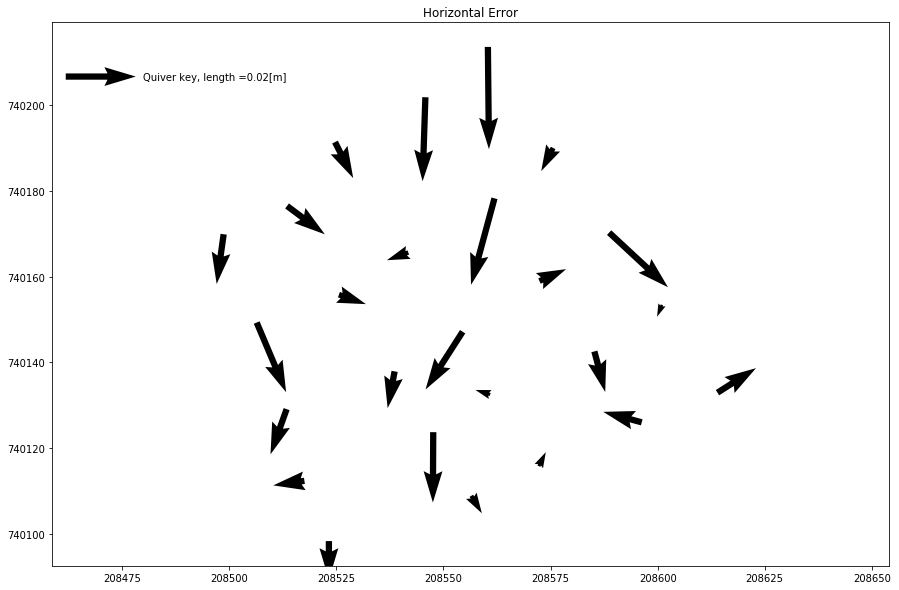

In [9]:
plot_errors(r'data\points_errors_5GCP_E_acc.csv',0.02)

In [24]:
# rms = pd.read_csv(r'data\points_errors_5GCP_E_acc.csv')
# # for i, row in rms.iterrows():
# #     rms.loc[i,'error'] = np.sqrt(row['Error X']**2+row['Error Y']**2+row['Error Z']**2)
# rms.loc['error'] =np.sqrt(rms.loc['Error X']**2 + rms.loc['Error Y']**2)

In [58]:
def nearest(row, gdf1, gdf2, geom_col1,geom_col2, src_column=None):
    """
    Find the nearest point and return the corresponding value from specified column
    :param row: row of gdf1
    :param gdf1: GeoDataFrame of points that we want to find their nearest point from gdf2
    :param gdf2: GeoDataFrame of points that we want to find the nearest point for them from gdf1
    :param geom_col1: Name of geometry column in df1
    :param geom_col2: Name of geometry column in df2
    :param src_column: Name of the column that contain the values
    :return: The values of the nearest points in new column of gdf1
    """
    geom_union = gdf2.geometry.unary_union
    # Find the geometry that is closest
    nearest_ = gdf2[geom_col2] == nearest_points(row[geom_col1], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = gdf2.loc[nearest_,src_column].to_numpy()[0]
    return value

In [11]:
gcp = pd.read_csv(r'data\GCP.csv')

In [52]:
# Create GoeDataFrame
points = gpd.points_from_xy(x=gcp.x, y=gcp.y)
gcp['geometry'] = points
gcp = gpd.GeoDataFrame(gcp, geometry='geometry', crs="EPSG:2039")

In [53]:
gcp1_5 = gcp.iloc[0:5,:]
# gcp1_5=gcp1_5.drop(columns='z')

In [59]:
# find the nearest GCP for every Check point
rms3['nearest_gcp'] = rms3.apply(nearest, gdf1=rms3,
                                 gdf2=gcp1_5, geom_col1='geometry',geom_col2='geometry' , src_column='point', axis=1)

In [ ]:
# Calc' the distances to the nearest GCP
for i,row in rms3.iterrows():
    nearest_name = rms3.loc[i,'nearest_gcp']
    nearest_point = rms3.loc[(rms3['point']==nearest_name)].geometry
    dist = np.sqrt((rms3.loc[i,'geometry'].x-nearest_point.x)**2+
                   (rms3.loc[i,'geometry'].y-nearest_point.y)**2).to_numpy()[0]
    rms3.loc[i,'distance_from_gcp'] = dist

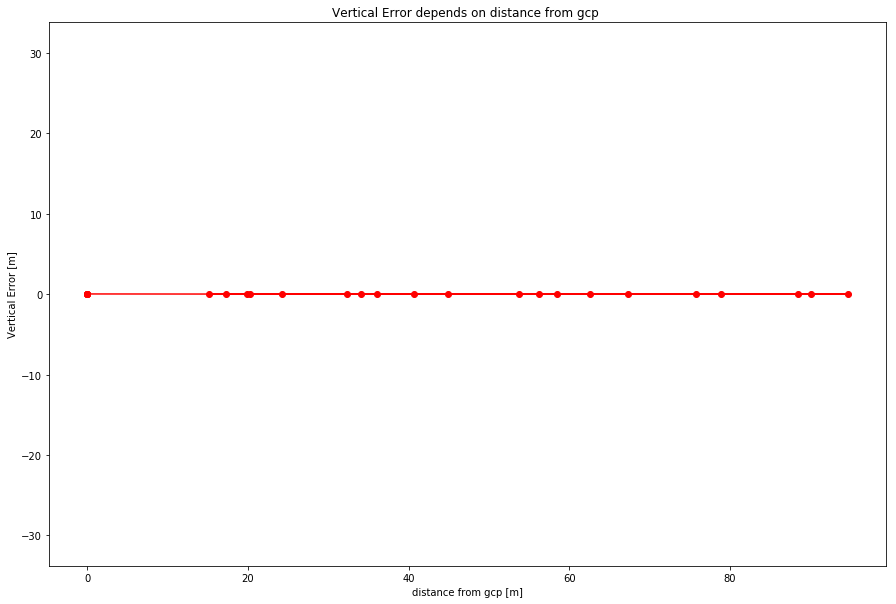

In [73]:
# plot vertical error
plt.figure(figsize=(15,10))
plt.plot(rms3['distance_from_gcp'],abs(rms3['Error Z']), 'r-o')
plt.title('Vertical Error depends on distance from gcp ')
plt.xlabel('distance from gcp [m]')
plt.ylabel('Vertical Error [m]')
plt.axis('equal')
plt.show()

Errors statistics: 
 count    25.000000
mean      0.013281
std       0.007201
min       0.003677
25%       0.008160
50%       0.011538
75%       0.019611
max       0.029202
Name: error, dtype: float64


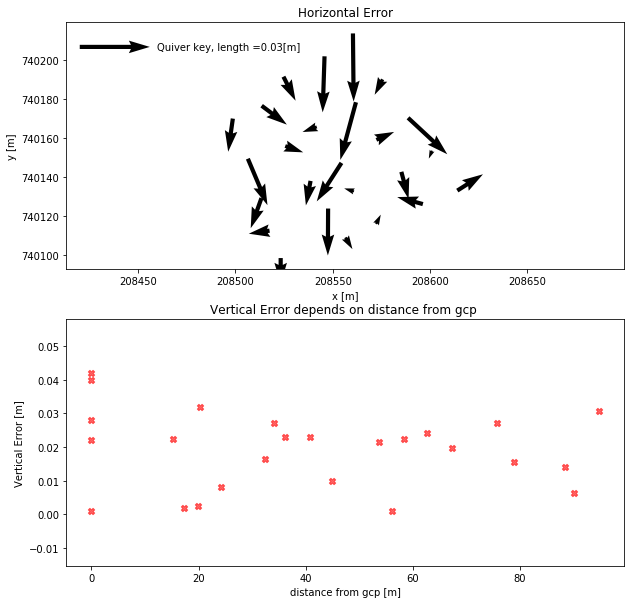

In [150]:
plot_errors(r'data\points_errors_5GCP_E_acc.csv',gcp.iloc[0:5,:], 0.03)

Errors statistics: 
 count    25.000000
mean      0.011975
std       0.007770
min       0.000608
25%       0.007071
50%       0.010730
75%       0.017839
max       0.027323
Name: error, dtype: float64


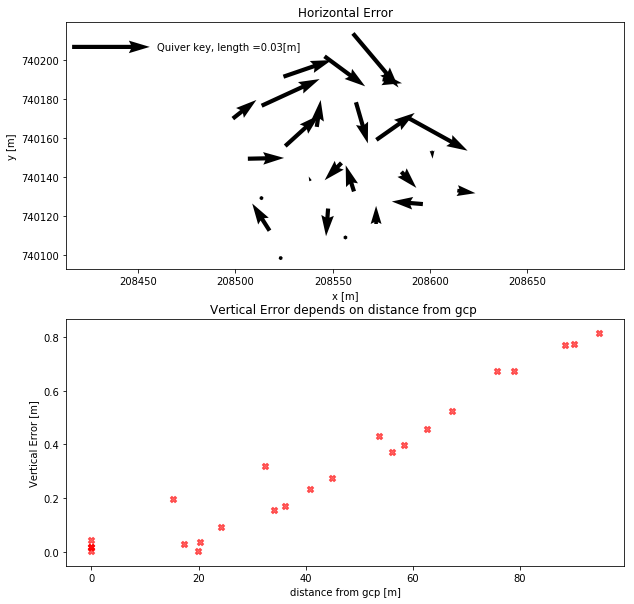

In [151]:
plot_errors(r'data\points_errors_5GCP_E_Inacc.csv',gcp.iloc[0:5,:], 0.03)

Errors statistics: 
 count    25.000000
mean     10.267489
std       0.015413
min      10.246266
25%      10.255194
50%      10.265070
75%      10.277850
max      10.305699
Name: error, dtype: float64


AttributeError: ("'Point' object has no attribute 'unary_union'", 'occurred at index 0')

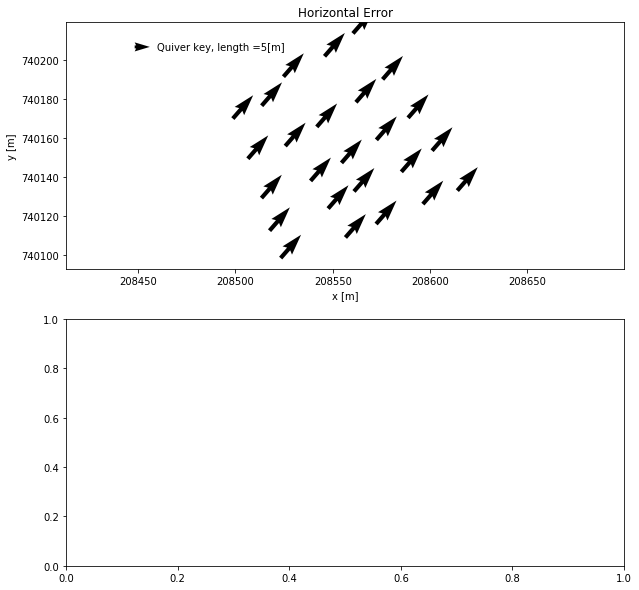

In [158]:
plot_errors(r'data\points_errors_1GCP_E_acc.csv',gcp.iloc[14,:], 5)

Errors statistics: 
 count    25.000000
mean      0.770806
std       0.327010
min       0.000000
25%       0.549524
50%       0.794081
75%       1.013138
max       1.344807
Name: error, dtype: float64


AttributeError: ("'Point' object has no attribute 'unary_union'", 'occurred at index 0')

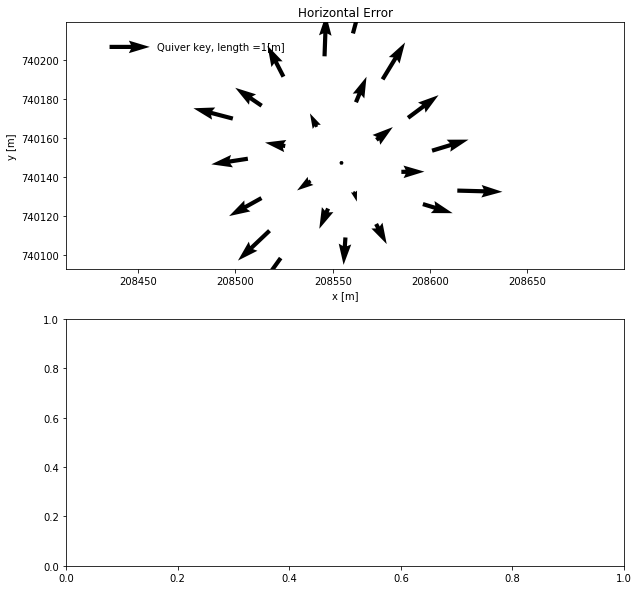

In [159]:
plot_errors(r'data\points_errors_1GCP_E_Inacc.csv',gcp.iloc[14,:], 1)


In [154]:
# choose 4 gcps from the corners
gcp_4=gcp.loc[(gcp['point'] == 'p1') | (gcp['point'] == 'p5') |
              (gcp['point'] == 'p9') | (gcp['point'] == 'p22')]

Errors statistics: 
 count    25.000000
mean      0.010714
std       0.004696
min       0.002326
25%       0.007086
50%       0.009719
75%       0.013800
max       0.018601
Name: error, dtype: float64


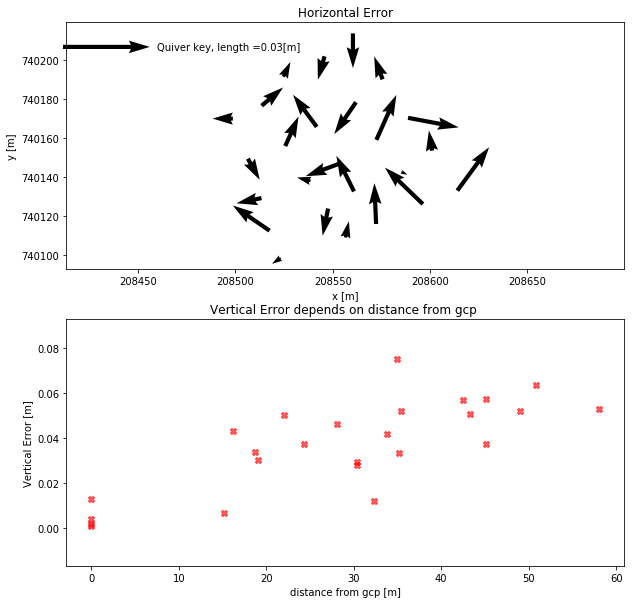

In [155]:
plot_errors(r'data\points_errors_4GCP_E_acc.csv',gcp_4, 0.03)

Errors statistics: 
 count    25.000000
mean      0.010234
std       0.004667
min       0.003960
25%       0.006230
50%       0.009801
75%       0.012492
max       0.022291
Name: error, dtype: float64


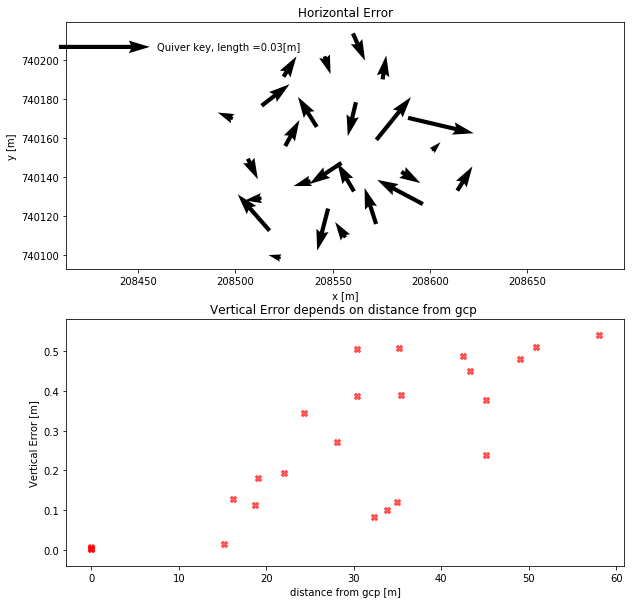

In [156]:
plot_errors(r'data\points_errors_4GCP_E_Inacc.csv',gcp_4, 0.03)

In [161]:
ttt = gcp.iloc[14,:]